In [1]:
import os, random, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

SEED = 42
tf.keras.utils.set_random_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))

try:
    from tensorflow.keras import mixed_precision
    if tf.config.list_physical_devices("GPU"):
        mixed_precision.set_global_policy("mixed_float16")
        print("Policy:", mixed_precision.global_policy())
    else:
        print("Policy: float32 (no GPU detected)")
except Exception as e:
    print("Mixed precision not enabled:", e)


2025-11-11 14:46:58.782739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762872418.977302      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762872419.025035      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Policy: <DTypePolicy "mixed_float16">


In [2]:
from pathlib import Path

ROOT = Path("/kaggle/input/brain-tumor-mri-classification")

TRAIN_DIR = ROOT / "Training" / "Training"
TEST_DIR  = ROOT / "Testing"  / "Testing"

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR :", TEST_DIR)


classes = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
num_classes = len(classes)
print("Classes:", classes, "| num_classes:", num_classes)
assert set(classes) == {"glioma","meningioma","notumor","pituitary"}, "Очікуємо 4 класи"


TRAIN_DIR: /kaggle/input/brain-tumor-mri-classification/Training/Training
TEST_DIR : /kaggle/input/brain-tumor-mri-classification/Testing/Testing
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary'] | num_classes: 4


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

SEED = 42
IMG_SIZE   = 192
BATCH_SIZE = 16
VAL_SPLIT  = 0.10


label_mode = "int"
final_units = num_classes
final_activation = "softmax"
loss_fn = keras.losses.SparseCategoricalCrossentropy()

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode=label_mode,
    class_names=classes,
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="training",
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode=label_mode,
    class_names=classes,
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    subset="validation",
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode=label_mode,
    class_names=classes,
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 32080 files belonging to 4 classes.
Using 28872 files for training.


I0000 00:00:1762872470.590042      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 32080 files belonging to 4 classes.
Using 3208 files for validation.
Found 8020 files belonging to 4 classes.


In [4]:
tf.config.optimizer.set_jit(False)

def configure(ds, training=False):
    if training:
        ds = ds.shuffle(512, seed=SEED, reshuffle_each_iteration=True)
    return ds.prefetch(1)

train_ds = configure(train_ds, training=True)
val_ds   = configure(val_ds,   training=False)
test_ds  = configure(test_ds,  training=False)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.10),
], name="augmentation")


In [5]:
def conv_block(x, filters, drop=0.25):
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x); x = layers.Dropout(drop)(x)
    return x

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)
x = data_augmentation(x)
x = conv_block(x, 32, 0.20)
x = conv_block(x, 64, 0.25)
x = conv_block(x, 128,0.30)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(final_units, activation=final_activation, dtype="float32")(x)

model = keras.Model(inputs, outputs, name="baseline_cnn")
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=loss_fn, metrics=["accuracy"])
model.summary()


Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 192, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 305,380 (1.16 MB)

 Trainable params: 304,484 (1.16 MB)

 Non-trainable params: 896 (3.50 KB)

In [6]:
EPOCHS = 50

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

best_path = "/kaggle/working/baseline_cnn_best.keras"

callbacks = [

    keras.callbacks.ModelCheckpoint(
        filepath=best_path,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=1
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),

    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=1e-4,
        restore_best_weights=True,
        verbose=1
    ),
]


In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

try:
    best_loaded = keras.models.load_model(best_path)
    model = best_loaded
    print("Loaded best model from:", best_path)
except Exception as e:
    print("Could not reload best model from file:", e)


Epoch 1/50


E0000 00:00:1762872494.655379      39 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/baseline_cnn_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1762872516.106920     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


1805/1805 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6392 - loss: 0.8836
Epoch 1: val_accuracy improved from -inf to 0.63965, saving model to /kaggle/working/baseline_cnn_best.keras
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 148s 65ms/step - accuracy: 0.6392 - loss: 0.8835 - val_accuracy: 0.6397 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 2/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7960 - loss: 0.5452
Epoch 2: val_accuracy improved from 0.63965 to 0.79395, saving model to /kaggle/working/baseline_cnn_best.keras
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - accuracy: 0.7960 - loss: 0.5452 - val_accuracy: 0.7940 - val_loss: 0.5483 - learning_rate: 0.0010
Epoch 3/50
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8304 - loss: 0.4534
Epoch 3: val_accuracy improved from 0.79395 to 0.81858, saving model to /kaggle/working/baseline_cnn_best.keras
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 117s 62ms/step - accuracy: 0.8304 - loss: 0.4534 - val_accuracy: 0.8186 - val_loss: 0.46

In [8]:
import tensorflow as tf, gc
try: del history
except: pass
gc.collect()

test_small = test_ds.unbatch().batch(2).prefetch(0)
with tf.device('/GPU:0'):
    test_loss, test_acc = model.evaluate(test_small, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Test accuracy: 0.9601 | Test loss: 0.1102


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Classification report:
               precision    recall  f1-score   support

      glioma     0.9640    0.9512    0.9576      1886
  meningioma     0.9435    0.9069    0.9248      1879
     notumor     0.9657    0.9953    0.9802      2317
   pituitary     0.9649    0.9783    0.9716      1938

    accuracy                         0.9601      8020
   macro avg     0.9595    0.9579    0.9585      8020
weighted avg     0.9599    0.9601    0.9598      8020



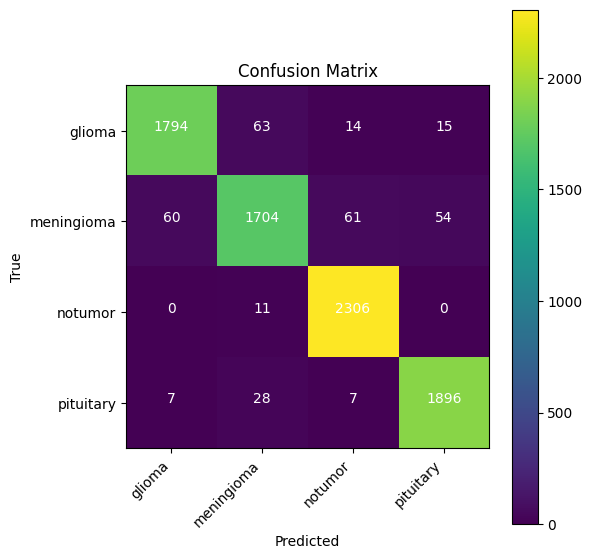

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf

y_true, y_pred = [], []
pred_ds = test_ds.unbatch().batch(2).prefetch(0)

with tf.device('/GPU:0'):
    for xb, yb in pred_ds:
        probs = model(xb, training=False)
        preds = np.argmax(probs.numpy(), axis=1)
        y_pred.extend(preds)
        y_true.extend(yb.numpy().astype("int32"))

y_true = np.array(y_true); y_pred = np.array(y_pred)

print("Classification report:\n",
      classification_report(y_true, y_pred, target_names=classes, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix"); plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
thresh = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j],
                 ha="center",
                 color="white")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.tight_layout(); plt.show()


In [14]:
final_path = "/kaggle/working/baseline_cnn_final.keras"
model.save(final_path)
print("Saved:", final_path)


Saved: /kaggle/working/baseline_cnn_final.keras
